In [1]:
import numpy as np
import os
import configparser
import shutil

from keras import layers
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model as plotn
from keras.optimizers import SGD

from keras import models

from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from collections import OrderedDict


import sys
sys.path.insert(0, './lib_keras/')
from help_functions import *

from lib_keras.model_lib import *
#function to obtain data for training/testing (validation)
from temp_extract_patches import temp_get_data_training

print(K.tensorflow_backend._get_available_gpus())


Using TensorFlow backend.
/home/bono/.pyenv/versions/3.5.5/envs/gpuTest/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bono/.pyenv/versions/3.5.5/envs/gpuTest/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bono/.pyenv/versions/3.5.5/envs/gpuTest/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np

['/job:localhost/replica:0/task:0/device:GPU:0']


## custom U-net Model

### Load Configuration

In [2]:
config = configparser.RawConfigParser()
config.read('configuration.txt')
#patch to the datasets
path_data = config.get('data paths', 'path_local')
#Experiment name
save_folder = config.get('experiment name','result_save_path')
name_experiment = config.get('experiment name', 'name')

#training settings
num_epochs = int(config.get('training settings', 'num_epochs'))
batch_size = int(config.get('training settings', 'batch_size'))

print(' path data : {}\n save_folder : {}\n name_experiment : {}\n num_epoches : {}\n batch_size : {}\n'.format(path_data, save_folder,\
                                                                                                               name_experiment,\
                                                                                                               num_epochs,batch_size))
'''
5 class
class01 (255,0,0), Red , RNFL
class02 (0,255,0), Green, other layers
class03 (0,0,255), Blue, RPE
class04 (255,255,0), Yellow, LC

'''
mapping = OrderedDict()
mapping[(0,0,0)] = 0
mapping[(255,0,0)] = 1
mapping[(0,0,255)] = 2


print(mapping)
print(len(mapping))
print('./'+save_folder+'/'+name_experiment+'/')




 path data : ./data/hdf5_data/inha_oct/
 save_folder : result
 name_experiment : 01_2class_borderSegTest
 num_epoches : 50
 batch_size : 8

OrderedDict([((0, 0, 0), 0), ((255, 0, 0), 1), ((0, 0, 255), 2)])
3
./result/01_2class_borderSegTest/


In [3]:
if os.path.isdir('./'+save_folder+'/'+name_experiment+'/') == False:
    os.mkdir('./'+save_folder+'/'+name_experiment+'/')
else:
    print('already exist the folder in this path : {}'.format('./'+save_folder+'/'+name_experiment+'/'))

already exist the folder in this path : ./result/01_2class_borderSegTest/


In [4]:
path_data + config.get('data paths', 'train_groundTruth')

# copy configuration

shutil.copyfile('./configuration.txt', './'+save_folder+'/'+name_experiment+'/configuration.txt')

'./result/01_2class_borderSegTest/configuration.txt'

### Extract patch for training

In [5]:
print(' train path : {}\n train label path : {}\n patch height : {} patch width : {}\n\
 num subimgs : {} \t inside FOV : {} \t save path : {}'.format(path_data + config.get('data paths', 'train_imgs_original'),\
                                                       path_data + config.get('data paths', 'train_groundTruth'),\
                                                       int(config.get('data attributes', 'patch_height')),\
                                                       int(config.get('data attributes', 'patch_width')),\
                                                       int(config.get('training settings', 'num_subimgs')),\
                                                       config.getboolean('training settings', 'inside_FOV'),\
                                                       save_folder+'/'+name_experiment))

 train path : ./data/hdf5_data/inha_oct/inha_oct_train.hdf5
 train label path : ./data/hdf5_data/inha_oct/inha_oct_groundTruth_train.hdf5
 patch height : 64 patch width : 64
 num subimgs : 100000 	 inside FOV : False 	 save path : result/01_2class_borderSegTest


In [6]:
patches_imgs_train, patches_masks_train, class_freq_tabel = temp_get_data_training(
    train_imgs_original = path_data + config.get('data paths', 'train_imgs_original'),
    train_groudTruth = path_data + config.get('data paths', 'train_groundTruth'),  #masks
    patch_height = int(config.get('data attributes', 'patch_height')),
    patch_width = int(config.get('data attributes', 'patch_width')),
    num_subimgs = int(config.get('training settings', 'num_subimgs')),
    label_mapping = mapping,
    inside_FOV = config.getboolean('training settings', 'inside_FOV'), #select the patches only inside the FOV  (default == True)
    save_path = save_folder+'/'+name_experiment
)
print('Done!')

already exist the folder in this path : result/01_2class_borderSegTest
number of subimages :  100000
[DEBUG] shape of train_imgs_original :  (35, 3, 500, 760)
[DEBUG] shape of train_imgs_label :  (35, 3, 500, 760)
[group images func] prev data shape  : (35, 3, 500, 760)
[group images func] after data shape :  (35, 500, 760, 3)
[group images func] first total image :  (500, 3800, 3)
[group images func] final total image :  (4000, 3800, 3)
data shape :  (4000, 3800, 3)
<PIL.Image.Image image mode=RGB size=3800x4000 at 0x7FB2217A65F8>
file name :  ./result/01_2class_borderSegTest/imgs_train
[group images func] prev data shape  : (35, 3, 500, 760)
[group images func] after data shape :  (35, 500, 760, 3)
[group images func] first total image :  (500, 3800, 3)
[group images func] final total image :  (4000, 3800, 3)
data shape :  (4000, 3800, 3)
<PIL.Image.Image image mode=RGB size=3800x4000 at 0x7FB2217A65F8>
file name :  ./result/01_2class_borderSegTest/imgs_labels
[DEBUG] normalize shape

./lib_keras/pre_processing.py:238: RuntimeWarning: invalid value encountered in true_divide
  imgs_normalized[i] = ((imgs_normalized[i] - np.min(imgs_normalized[i])) / (np.max(imgs_normalized[i])-np.min(imgs_normalized[i])))*255


[group images func] prev data shape  : (35, 1, 500, 760)
[group images func] after data shape :  (35, 500, 760, 1)
[group images func] first total image :  (500, 3800, 1)
[group images func] final total image :  (4000, 3800, 1)
data shape :  (4000, 3800, 1)
<PIL.Image.Image image mode=L size=3800x4000 at 0x7FB2217A6E80>
file name :  ./result/01_2class_borderSegTest/preprocessed


[get_data_training] preprocessed image shape :  (35, 1, 500, 760)

[get_data_training] preprocessed mask shape :  (35, 3, 500, 760)
mask maximum val :  255.0
[get_data_training] preprocessed2 image shape :  (35, 1, 500, 760)


[padding] pad h size : 12	 pad w size : 8


[padding] imgs shape : (35, 500, 760, 1)	 labels shape : (35, 500, 760, 3)


[padding] pad imgs shape : (35, 512, 768, 1)	 pad labels shape : (35, 512, 768, 3)


extract patches:   0%|          | 0/35 [00:00<?, ?it/s]



[final pad] imgs shape : (35, 512, 768, 1)	 labels shape : (35, 512, 768, 3)


[final transpose] imgs shape : (35, 1, 512, 768)	 labels shape : (35, 3, 512, 768)


[get_data_training] train images/masks shape : (35, 1, 512, 768)
[get_data_training] train images range (min-max) [0.0 , 1.0] 
[get_data_training] train masks are within 0-1



[extract random] num of class :  3
[extract random] full image shape : (35, 1, 512, 768)
[extract random] full masks shape : (35, 3, 512, 768)
[extract random] patches shape : (100000, 1, 64, 64)
[extract random] patches masks shape : (100000, 3, 64, 64)
[extract random] patches per full image : 2857


extract patches: 100%|██████████| 35/35 [02:19<00:00,  3.99s/it]


[After patch] mask shape :  (100000, 3, 64, 64)
[Augmentation function] patches shape :  (100000, 1, 64, 64)
[Augmentation function] augmentation patches shape :  (100000, 64, 64, 1)
[Augmentation function] augmentation patches masks shape :  (100000, 64, 64, 3)


[get_data_training] train PATCHES images/masks shape : (100000, 1, 64, 64)
[get_data_training] train PATCHES images range (min-max): 0.0 - 1.0
[get_data_training] patches_imgs_train : (100000, 1, 64, 64)
[group images func] prev data shape  : (50, 1, 64, 64)
[group images func] after data shape :  (50, 64, 64, 1)
[group images func] first total image :  (64, 320, 1)
[group images func] final total image :  (704, 320, 1)
data shape :  (704, 320, 1)
<PIL.Image.Image image mode=L size=320x704 at 0x7FB22172A6A0>
file name :  ./result/01_2class_borderSegTest/train_patch_img
Done!


In [7]:
class_freq_tabel



,class_0,class_1,class_2,frequency_0,frequency_1,frequency_2
0,11686830,7104,8338,0.99868,0.000607062,0.000712511
1,11682017,6808,13447,0.998269,0.000581767,0.00114909
2,11688266,3898,10108,0.998803,0.000333098,0.000863764
3,11686630,5208,10434,0.998663,0.000445042,0.000891622
4,11687919,5457,8896,0.998773,0.00046632,0.000760194
5,11681874,6869,13529,0.998257,0.00058698,0.0011561
6,11702272,0,0,1,0,0
7,11684340,6140,11792,0.998468,0.000524684,0.00100767
8,11690179,4115,7978,0.998967,0.000351641,0.000681748
9,11688236,5582,8454,0.998801,0.000477001,0.000722424


In [8]:
import pandas as pd

average_class_freq = pd.DataFrame(columns=['avg_class_00', 'avg_class_01', 'avg_class_02', 'avg_freq_00','avg_freq_01','avg_freq_02'])

average_class_freq.loc[0,'avg_class_00'] = class_freq_tabel['class_0'].mean()
average_class_freq.loc[0,'avg_class_01'] = class_freq_tabel['class_1'].mean()
average_class_freq.loc[0,'avg_class_02'] = class_freq_tabel['class_2'].mean()


average_class_freq.loc[0,'avg_freq_00'] = class_freq_tabel['frequency_0'].mean()
average_class_freq.loc[0,'avg_freq_01'] = class_freq_tabel['frequency_1'].mean()
average_class_freq.loc[0,'avg_freq_02'] = class_freq_tabel['frequency_2'].mean()

average_class_freq

,avg_class_00,avg_class_01,avg_class_02,avg_freq_00,avg_freq_01,avg_freq_02
0,1.16856e+07,4985.43,11733.6,0.998571,0.000426022,0.00100268


In [9]:
class_freq_tabel.to_csv('./'+save_folder+'/'+name_experiment+'/'+'all_class_imbalance.csv', encoding='utf-8')
average_class_freq.to_csv('./'+save_folder+'/'+name_experiment+'/'+'avg_class_imbalance.csv', encoding='utf-8')


In [10]:

patches_masks_train_class00 = patches_masks_train[:,0,:,:] 
patches_masks_train_class00 = np.expand_dims(patches_masks_train_class00,1)
patches_masks_train_class01 = patches_masks_train[:,1,:,:] 
patches_masks_train_class01 = np.expand_dims(patches_masks_train_class01,1)
patches_masks_train_class02 = patches_masks_train[:,2,:,:] 
patches_masks_train_class02 = np.expand_dims(patches_masks_train_class02,1)



print(np.shape(patches_masks_train_class00))

(100000, 1, 64, 64)


### Visualizing

[group images func] prev data shape  : (40, 1, 64, 64)
[group images func] after data shape :  (40, 64, 64, 1)
[group images func] first total image :  (64, 320, 1)
[group images func] final total image :  (576, 320, 1)
data shape :  (576, 320, 1)
<PIL.Image.Image image mode=L size=320x576 at 0x7FB22018C7F0>
file name :  ./result/01_2class_borderSegTest/sample_input_imgs
[group images func] prev data shape  : (40, 1, 64, 64)
[group images func] after data shape :  (40, 64, 64, 1)
[group images func] first total image :  (64, 320, 1)
[group images func] final total image :  (576, 320, 1)
data shape :  (576, 320, 1)
<PIL.Image.Image image mode=L size=320x576 at 0x7FB22018C7B8>
file name :  ./result/01_2class_borderSegTest/sample_input_masks_claass0
[group images func] prev data shape  : (40, 1, 64, 64)
[group images func] after data shape :  (40, 64, 64, 1)
[group images func] first total image :  (64, 320, 1)
[group images func] final total image :  (576, 320, 1)
data shape :  (576, 320

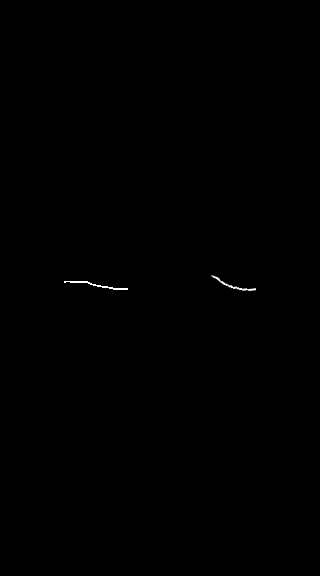

In [11]:
N_sample = min(patches_imgs_train.shape[0],40)
visualize(group_images(patches_imgs_train[0:N_sample,:,:,:],5),'./'+save_folder+'/'+name_experiment+'/'+"sample_input_imgs")#.show()
visualize(group_images(patches_masks_train_class00[0:N_sample,:,:,:],5),'./'+save_folder+'/'+name_experiment+'/'+"sample_input_masks_claass0")#.show()
visualize(group_images(patches_masks_train_class01[0:N_sample,:,:,:],5),'./'+save_folder+'/'+name_experiment+'/'+"sample_input_masks_claass1")#.show()
visualize(group_images(patches_masks_train_class02[0:N_sample,:,:,:],5),'./'+save_folder+'/'+name_experiment+'/'+"sample_input_masks_claass2")#.show()


### Model fitting

In [12]:
n_ch = patches_imgs_train.shape[1]
patch_height = patches_imgs_train.shape[2]
patch_width = patches_imgs_train.shape[3]
print('shape : ',patches_imgs_train.shape)
print('n_ch : {} patch_h : {} patch_w : {}'.format(n_ch, patch_height, patch_width))
#model = naive_attn_unet(n_ch, patch_height, patch_width)  #the U-net model
#model = unet_norm(n_ch, patch_height, patch_width,len(mapping))
#model = naive_attn_unet(n_ch, patch_height, patch_width,len(mapping))

#model = bigger_unet_norm(n_ch, patch_height, patch_width,len(mapping))
#model = bigger_naive_attn_unet(n_ch, patch_height, patch_width,len(mapping))
model = class3_attn_unet(n_ch, patch_height, patch_width,len(mapping))
#model = attn_reg_test(n_ch, patch_height, patch_width,len(mapping))

print ("Check: final output of the network:")
print (model.output_shape)

#plot(model, to_file= './'+save_folder+'/'+name_experiment+'/' +name_experiment+ '_model.png')   #check how the model looks like
#plot(model, to_file= name_experiment+'/'+name_experiment + '_model.png')   #check how the model looks like

json_string = model.to_json()
open('./'+save_folder+'/'+name_experiment+'/' +name_experiment+'_architecture.json', 'w').write(json_string)


shape :  (100000, 1, 64, 64)
n_ch : 1 patch_h : 64 patch_w : 64
input shape :  (None, 1, 64, 64)

gating shape : (None, 128, 4, 4), conv4 shape : (None, 64, 8, 8)
shape x,g  (None, 64, 8, 8) (None, 128, 4, 4)
inter shape :   128
stride x : 1 stride y : 1
theta_x shape :  (None, 128, 4, 4)
upsample_g shape :  (None, 128, 4, 4)

attn1 shape : (None, 64, 8, 8) center shape : (None, 128, 4, 4) 

attn1 shape : (None, 64, 8, 8) up1 shape : (None, 128, 8, 8)
shape x,g  (None, 64, 16, 16) (None, 128, 8, 8)
inter shape :   64
stride x : 1 stride y : 1
theta_x shape :  (None, 64, 8, 8)
upsample_g shape :  (None, 64, 8, 8)
shape x,g  (None, 32, 32, 32) (None, 128, 16, 16)
inter shape :   64
stride x : 1 stride y : 1
theta_x shape :  (None, 64, 16, 16)
upsample_g shape :  (None, 64, 16, 16)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (Inp

41736

### Training Session

In [13]:
'''
Keras provides a set of functions called callbacks: 
you can think of callbacks as events that will be triggered at certain training states. 
The callback we need for checkpointing is the ModelCheckpoint 
which provides all the features we need according to the checkpointing strategy we adopted in our example
'''

checkpointer = ModelCheckpoint(filepath='./'+save_folder+'/'+name_experiment+'/best_weights.h5', verbose=1, monitor='val_loss', mode='auto', save_best_only=True) #save at each epoch if the validation decreased

print('[training session] mask unet func patch mask shape :q ',patches_masks_train.shape)
patches_masks_train = np.reshape(patches_masks_train, (patches_masks_train.shape[0], len(mapping), patch_height* patch_width))
patches_masks_train = np.transpose(patches_masks_train,(0,2,1))
#patches_masks_train = masks_Unet(patches_masks_train)  #reduce memory consumption
print('[training session] After mask unet func patch mask shape : ',patches_masks_train.shape)






[training session] mask unet func patch mask shape :q  (100000, 3, 64, 64)
[training session] After mask unet func patch mask shape :  (100000, 4096, 3)


In [14]:
try:
    history = model.fit(patches_imgs_train, patches_masks_train, epochs=num_epochs, batch_size=batch_size, verbose=1, shuffle=True, validation_split=0.2, callbacks=[checkpointer])
    model.save_weights('./'+save_folder+'/'+name_experiment +'/last_weights.h5', overwrite=False)
except KeyboardInterrupt:
    model.save_weights('./'+save_folder+'/'+name_experiment +'/last_weights.h5', overwrite=False)
    print('Keyboard Interrupt')

Train on 80000 samples, validate on 20000 samples
Epoch 1/50
80000/80000 [==============================] - 621s 8ms/step - loss: 26.5054 - generalized_dice_coeff: 0.7433 - val_loss: 1.4454 - val_generalized_dice_coeff: 0.8603

Epoch 00001: val_loss improved from inf to 1.44544, saving model to ./result/01_2class_borderSegTest/best_weights.h5
Epoch 2/50
80000/80000 [==============================] - 616s 8ms/step - loss: 1.2421 - generalized_dice_coeff: 0.8750 - val_loss: 1.3696 - val_generalized_dice_coeff: 0.8926

Epoch 00002: val_loss improved from 1.44544 to 1.36962, saving model to ./result/01_2class_borderSegTest/best_weights.h5
Epoch 3/50
80000/80000 [==============================] - 616s 8ms/step - loss: 1.1822 - generalized_dice_coeff: 0.8804 - val_loss: 1.3540 - val_generalized_dice_coeff: 0.8425

Epoch 00003: val_loss improved from 1.36962 to 1.35396, saving model to ./result/01_2class_borderSegTest/best_weights.h5
Epoch 4/50
80000/80000 [==============================] - 6

[WARNING] ./result/01_2class_borderSegTest/last_weights.h5 already exists - overwrite? [y/n] y


[TIP] Next time specify overwrite=True!


In [ ]:
history = model.fit(patches_imgs_train, patches_masks_train, epochs=num_epochs, batch_size=batch_size, verbose=1, shuffle=True, validation_split=0.2, callbacks=[checkpointer])
model.save_weights('./'+save_folder+'/'+name_experiment +'/last_weights.h5', overwrite=False)

In [ ]:
'''
Keras provides a set of functions called callbacks: 
you can think of callbacks as events that will be triggered at certain training states. 
The callback we need for checkpointing is the ModelCheckpoint 
which provides all the features we need according to the checkpointing strategy we adopted in our example


checkpointer = ModelCheckpoint(filepath='./'+save_folder+'/'+name_experiment+'/best_weights.h5', verbose=1, monitor='val_loss', mode='auto', save_best_only=True) #save at each epoch if the validation decreased

print('[training session] before mask unet func patch mask shape : ',patches_masks_train.shape)
patches_masks_train = masks_Unet(patches_masks_train)  #reduce memory consumption
print('[training session] after mask unet func patch mask shape : ',patches_masks_train.shape)

#print(len(x_train))
history = model.fit_generator(data_gen.flow(patches_imgs_train,patches_masks_train,batch_size=batch_size,subset='training'), 
                              steps_per_epoch=len(patches_imgs_train)/batch_size,epochs=num_epochs, verbose=1,shuffle=True, callbacks=[checkpointer],
                             validation_data = data_gen.flow(patches_imgs_train,patches_masks_train,batch_size=batch_size,subset='validation'),
                             validation_steps = 10)
model.save_weights('./'+save_folder+'/'+name_experiment +'/last_weights.h5', overwrite=True) '''


dict_keys(['generalized_dice_coeff', 'val_generalized_dice_coeff', 'val_loss', 'loss'])


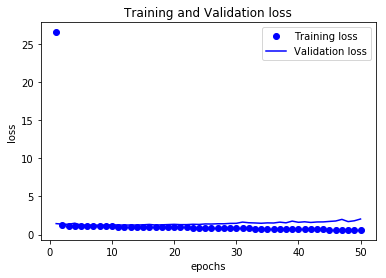

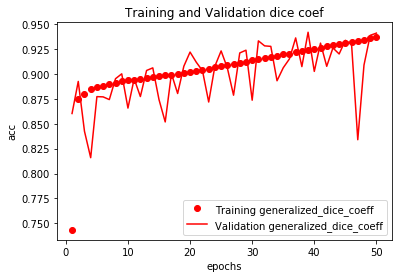

already exist the folder in this path : ./result/01_2class_borderSegTest/train_history
already exist the folder in this path : ./result/01_2class_borderSegTest/train_history
already exist the folder in this path : ./result/01_2class_borderSegTest/train_history


In [17]:
import matplotlib.pyplot as plt

print(history.history.keys())

loss = history.history['loss']
val_loss= history.history['val_loss']
acc = history.history['generalized_dice_coeff']
val_acc = history.history['val_generalized_dice_coeff']

epochs = range(1,len(acc) +1)

plt.plot(epochs, loss, 'bo', label = "Training loss")
plt.plot(epochs, val_loss, 'b', label = "Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("epochs")
plt.ylabel('loss')
plt.legend()
plt.savefig('./'+save_folder+'/'+name_experiment+"/training_loss_result.png")
plt.figure()

plt.plot(epochs, acc, 'ro', label = "Training generalized_dice_coeff")
plt.plot(epochs, val_acc, 'r', label = "Validation generalized_dice_coeff")
plt.title("Training and Validation dice coef")
plt.xlabel("epochs")
plt.ylabel('acc')
plt.legend()


plt.savefig('./'+save_folder+'/'+name_experiment+"/training_acc_result.png")
plt.show()

import pandas as pd
file_path = './'+save_folder+'/'+name_experiment + '/' + 'train_history'

def save_history_txt_csv(history, file_path, file_name):
    if os.path.isdir(file_path) == False:
        os.mkdir(file_path)
    else:
        print('already exist the folder in this path : {}'.format(file_path))
    
    hist_df = pd.DataFrame(history) 

    # save to json:  
    hist_json_file = file_path + '/' + file_name +'.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = file_path + '/' + file_name + '.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        

save_history_txt_csv(loss, file_path, 'train_loss')
save_history_txt_csv(val_loss, file_path, 'val_loss')
save_history_txt_csv(acc, file_path, 'train_acc')
save_history_txt_csv(val_acc, file_path, 'val_acc')

In [ ]:
import pandas as pd
file_path = './'+save_folder+'/'+name_experiment + '/' + 'train_history'

def save_history_txt_csv(history, file_path, file_name):
    if os.path.isdir(file_path) == False:
        os.mkdir(file_path)
    else:
        print('already exist the folder in this path : {}'.format(file_path))
    
    hist_df = pd.DataFrame(history) 

    # save to json:  
    hist_json_file = file_path + '/' + file_name +'.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = file_path + '/' + file_name + '.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        

save_history_txt_csv(loss, file_path, 'train_loss')
save_history_txt_csv(val_loss, file_path, 'val_loss')
save_history_txt_csv(acc, file_path, 'train_acc')
save_history_txt_csv(val_acc, file_path, 'val_acc')

## 

In [ ]:
import matplotlib.pyplot as plt

print(history.history.keys())

loss = history.history['loss']
val_loss= history.history['val_loss']
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']

epochs = range(1,len(acc) +1)

plt.plot(epochs, loss, 'bo', label = "Training loss")
plt.plot(epochs, val_loss, 'b', label = "Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("epochs")
plt.ylabel('loss')
plt.legend()
plt.savefig('./'+save_folder+'/'+name_experiment+"/training_loss_result.png")
plt.figure()

plt.plot(epochs, acc, 'ro', label = "Training dice coef")
plt.plot(epochs, val_acc, 'r', label = "Validation dice coef")
plt.title("Training and Validation dice coef")
plt.xlabel("epochs")
plt.ylabel('acc')
plt.legend()


plt.savefig('./'+save_folder+'/'+name_experiment+"/training_acc_result.png")
plt.show()